# Implement probabilistic scores for ensemble forecasts
 
Now let's implement the ensemble scores. Please refer to the Dropbox document for their definition. 

1. Spread/Skill ratio: As mentioned in Scher and Messori (2020) there is a right way to do the order of the computations. Read their paragraph on it.
2. CRPS: Try the `properscoring` package. This one should be good.
3. Rank histogram: Try the `rankhistogram` package. No idea if this one is good. If it's ok but requires minor changes, we can consider a pull request. Otherwise, let's just write our own implementation. 

For all three scores:
- Use `xarray` as much as possible. Write a function similar to `src.score.compute_weighted_rmse.py`. 
- Ignore the weighted part at first.
- Create simple synthetic datasets to test extreme cases. E.g. `ensemble = [1, 1, 1]`, `obs=[1]` should result in a CRPS of 0. Think about what good sanity checks are for each score. For the rank histogram, for example, try to build examples that should end up in the shapes from the Dropbox document (overdispersion, underdispersion, etc.)
- Test the three functions with the "real" data from the dropout ensemble.
- Now the weighted part: Because the area of each lat-lon square is not the same but in fact varies with cos(lat), we want to weigh each grid point proportional to its area. This is already implemented for the rmse and acc scores in `src/score.py`. Implement this for the three probabilistic scores and compare to the unweighted scores. They shouldn't be too different. Implementing this for the rank histogram might require some thinking. We can talk about this together.

ToDo:
- make crps work for full data. try loading in batches.
- see rank histogram. maybe can make it faster.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import matplotlib.pyplot as plt

In [3]:
# # You only need this if you are using a GPU
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [4]:
# tf.compat.v1.disable_eager_execution() #needed
tf.__version__
!pwd

/home/garg/WeatherBench/nbs_probabilistic


In [5]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/82-resnet_d3_dr_0.2.yml'
model_save_dir='/home/garg/data/WeatherBench/predictions/saved_models'
datadir='/home/garg/data/WeatherBench/5.625deg'
pred_save_dir='/home/garg/data/WeatherBench/predictions'

In [6]:
!ls $pred_save_dir

01-resnet_baseline.nc  80-resnet_d3_dr_0.05.nc	82-resnet_d3_dr_0.2.nc
02-resnet_2dt.nc       81-resnet_d3_dr_0.1.nc	saved_models


In [7]:
start_date='2017-01-01'; end_date='2017-03-31'
start_date='2017-01-01'; end_date='2017-12-31'

In [7]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/82-resnet_d3_dr_0.2.yml'
!python create_dropout_ensemble.py 100 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir} {start_date} {end_date}

DG start 10:21:04.237300
DG normalize 10:21:04.251525
DG load 10:21:04.256906
Loading data into RAM
DG done 10:21:12.153200
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-05-04 10:21:12.376316: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-04 10:21:12.380605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-04 10:21:12.381093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2020-05-04 10:21:12.381203: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-05-04 10:21:12.381865: I tensorflow/stream_executor/platform/default/

In [8]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/81-resnet_d3_dr_0.1.yml'
!python create_dropout_ensemble.py 100 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir} {start_date} {end_date}

DG start 11:01:10.906396
DG normalize 11:01:10.920439
DG load 11:01:10.925811
Loading data into RAM
DG done 11:01:18.939729
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-05-04 11:01:19.169576: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-04 11:01:19.175698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-04 11:01:19.176190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2020-05-04 11:01:19.176408: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-05-04 11:01:19.179149: I tensorflow/stream_executor/platform/default/

In [9]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/80-resnet_d3_dr_0.05.yml'
!python create_dropout_ensemble.py 100 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir} {start_date} {end_date}

DG start 11:41:31.632699
DG normalize 11:41:31.646757
DG load 11:41:31.652118
Loading data into RAM
DG done 11:41:39.539479
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-05-04 11:41:39.777220: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-04 11:41:39.783398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-04 11:41:39.783919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2020-05-04 11:41:39.784145: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-05-04 11:41:39.787153: I tensorflow/stream_executor/platform/default/

In [8]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/81-resnet_d3_dr_0.1.yml'


args=load_args(exp_id_path)
exp_id=args['exp_id']
var_dict=args['var_dict']
batch_size=args['batch_size']
output_vars=args['output_vars']

#Question: how to optionally  input data_subsample, norm_subsample, nt_in, dt_in, test_years?
data_subsample=args['data_subsample']
norm_subsample=args['norm_subsample']
nt_in=args['nt_in']
dt_in=args['dt_in']
test_years=args['test_years']
lead_time=args['lead_time']


In [9]:
preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

In [10]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 100, time: 4342)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * time     (time) datetime64[ns] 2017-01-04T04:00:00 ... 2017-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (member, time, lat, lon) float64 ...
    t_850    (member, time, lat, lon) float64 ...

In [11]:
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't')

In [12]:
observation=xr.Dataset()
observation['z_500']=z500_valid
observation['t_850']=t850_valid

In [13]:
observation=observation.astype('float64')
observation=observation.drop('level')

In [14]:
# observation=observation.sel(time=preds.time)
# assert (observation.time==preds.time).all

In [15]:
observation

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z_500    (time, lat, lon) float64 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t_850    (time, lat, lon) float64 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

In [16]:
observation.t_850.values[0:3,0,0] #unnormalized already

array([257.84133911, 257.58569336, 257.3553772 ])

In [17]:
tigge_dir='/home/garg/data/WeatherBench/tigge/5.625deg'

In [18]:
tigge_var_list=['geopotential_500_ens','temperature_850_ens']
#tigge_var_list=['temperature_850_ens']

tigge=xr.merge([xr.open_mfdataset(f'{tigge_dir}/{var}/*.nc'
                        , combine='by_coords') for var in tigge_var_list], compat="override")
# Compat="override" is fine. The problem is that one var is at 500hPa , the other at 850hPa.

In [19]:
# Note that "time" is the initialization time of the forecast, not the valid time!
tigge

<xarray.Dataset>
Dimensions:        (lat: 32, lon: 64, number: 50, step: 8, time: 1460)
Coordinates:
    isobaricInhPa  int64 500
  * step           (step) timedelta64[ns] 0 days 1 days 2 days ... 6 days 7 days
  * number         (number) int64 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50
  * lat            (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon            (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * time           (time) datetime64[ns] 2017-01-01 ... 2018-12-31T12:00:00
    valid_time     (time, step) datetime64[ns] dask.array<chunksize=(62, 8), meta=np.ndarray>
Data variables:
    gh             (number, time, step, lat, lon) float32 dask.array<chunksize=(50, 62, 8, 32, 64), meta=np.ndarray>
    t              (number, time, step, lat, lon) float32 dask.array<chunksize=(50, 62, 8, 32, 64), meta=np.ndarray>

In [20]:
# Let's now pick the 3 day forecast
tigge = tigge.sel(step='3 days')
# Now we want time to be the valid time
tigge['time'] = tigge['valid_time']

In [21]:
# Rename
tigge = tigge.rename({'number': 'member', 'gh':'z_500','t':'t_850'})
# Convert geopotential height to geopotential
tigge['z_500'] *= 9.806

In [22]:
tigge

<xarray.Dataset>
Dimensions:        (lat: 32, lon: 64, member: 50, time: 1460)
Coordinates:
    isobaricInhPa  int64 500
    step           timedelta64[ns] 3 days
  * member         (member) int64 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50
  * lat            (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon            (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * time           (time) datetime64[ns] 2017-01-04 ... 2019-01-03T12:00:00
    valid_time     (time) datetime64[ns] dask.array<chunksize=(62,), meta=np.ndarray>
Data variables:
    z_500          (member, time, lat, lon) float32 dask.array<chunksize=(50, 62, 32, 64), meta=np.ndarray>
    t_850          (member, time, lat, lon) float32 dask.array<chunksize=(50, 62, 32, 64), meta=np.ndarray>

In [23]:
tigge.z_500.values.shape

(50, 1460, 32, 64)

In [24]:
tigge.t_850.values[0,0:5,0,0], tigge.z_500.values[0,0:5,0,0] #magnitude of z is wrong.

(array([258.87042, 257.26797, 259.67017, 259.9244 , 258.9179 ],
       dtype=float32),
 array([51355.71 , 51360.73 , 51272.797, 50851.43 , 50576.   ],
       dtype=float32))

# Evaluation methods: Spread-skill, CRPS, Rank histogram
check src/score.py.

### Spread/skill for Tigge

In [44]:
preds.time

<xarray.DataArray 'time' (time: 4342)>
array(['2017-01-04T04:00:00.000000000', '2017-01-04T06:00:00.000000000',
       '2017-01-04T08:00:00.000000000', ..., '2017-12-31T18:00:00.000000000',
       '2017-12-31T20:00:00.000000000', '2017-12-31T22:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T04:00:00 ... 2017-12-31T22:00:00
Attributes:
    long_name:  time

In [45]:
tigge.time

<xarray.DataArray 'time' (time: 1460)>
array(['2017-01-04T00:00:00.000000000', '2017-01-04T12:00:00.000000000',
       '2017-01-05T00:00:00.000000000', ..., '2019-01-02T12:00:00.000000000',
       '2019-01-03T00:00:00.000000000', '2019-01-03T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    isobaricInhPa  int64 500
    step           timedelta64[ns] 3 days
  * time           (time) datetime64[ns] 2017-01-04 ... 2019-01-03T12:00:00
    valid_time     (time) datetime64[ns] dask.array<chunksize=(62,), meta=np.ndarray>
Attributes:
    standard_name:  time
    long_name:      time

In [46]:
observation.time

<xarray.DataArray 'time' (time: 17520)>
array(['2017-01-01T00:00:00.000000000', '2017-01-01T01:00:00.000000000',
       '2017-01-01T02:00:00.000000000', ..., '2018-12-31T21:00:00.000000000',
       '2018-12-31T22:00:00.000000000', '2018-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Attributes:
    long_name:  time

In [25]:
# So all of these have different times. 
# Let's just chose 2017
preds = preds.sel(time='2017')
tigge = tigge.sel(time='2017')
observation = observation.sel(time='2017')

In [51]:
mean_spread = []
mean_error = []
# It's always better to avoid copying code. 
# Here I use a loop over the different forecasts.
# Another option would be to write a function
for ds in [preds, tigge]:
    mean_spread.append(compute_weighted_meanspread(ds).load())
    ens_mean = ds.mean('member')
    mean_error.append(compute_weighted_rmse(ens_mean, observation).load())

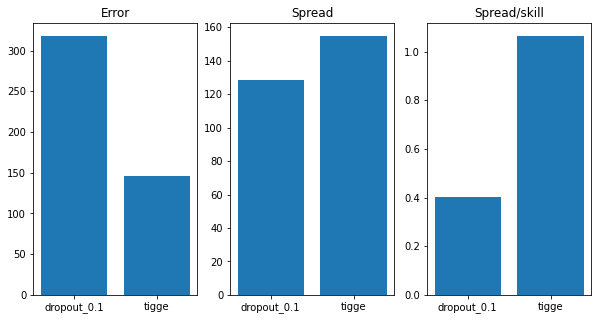

In [63]:
# I like plotting everything instead of just looking at numbers
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.bar(['dropout_0.1', 'tigge'], [ds.z_500_rmse for ds in mean_error])
ax2.bar(['dropout_0.1', 'tigge'], [ds.z_500_mean_spread for ds in mean_spread])
ax3.bar(['dropout_0.1', 'tigge'], [ds1.z_500_mean_spread / ds2.z_500_rmse 
                                   for ds1, ds2 in zip(mean_spread, mean_error)])
ax1.set_title('Error')
ax2.set_title('Spread')
ax3.set_title('Spread/skill');

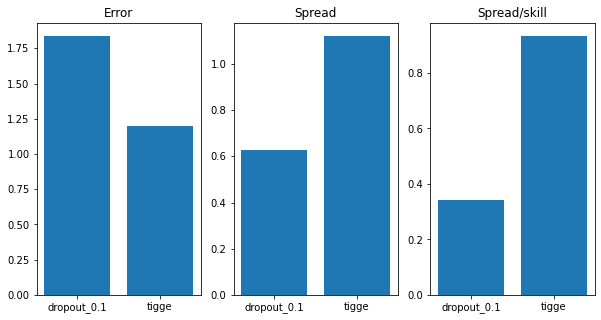

In [64]:
# I like plotting everything instead of just looking at numbers
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.bar(['dropout_0.1', 'tigge'], [ds.t_850_rmse for ds in mean_error])
ax2.bar(['dropout_0.1', 'tigge'], [ds.t_850_mean_spread for ds in mean_spread])
ax3.bar(['dropout_0.1', 'tigge'], [ds1.t_850_mean_spread / ds2.t_850_rmse 
                                   for ds1, ds2 in zip(mean_spread, mean_error)])
ax1.set_title('Error')
ax2.set_title('Spread')
ax3.set_title('Spread/skill');

So we have a much lower error for tigge and a larger spread. The spread skill for tigge is close to one, whereas for the dropout is is <0.5, so totally underdispersive.

# Method 2: CRPS

In [26]:
# Let's try xskillscore instead of properscoring. It seems to be more maintained.
import xskillscore as xs

In [39]:
def compute_weighted_crps(da_fc, da_true, mean_dims=xr.ALL_DIMS):
    weights_lat = np.cos(np.deg2rad(da_fc.lat))
    weights_lat /= weights_lat.mean()
    crps = xs.crps_ensemble(da_true, da_fc)
    crps = (crps * weights_lat).mean(mean_dims)
    return crps

Usually taking mean().load() will blow up the CPU RAM. This is because it will try to load all the data at once. Xarray is able to do distributed computations though using dask in the background. We can specify that the data should be treaded as separate chunks along a dimension. Then the computations will be executed for a chunk at a time. See the xarray documentation "Parallel computing" for reference.

It still uses up a lot of memory but now is manageable.

In [40]:
observation = observation.chunk({'time': 500})

In [41]:
# Unfortunately xs requires the time arrays to be equal
crps_dr = compute_weighted_crps(preds, observation.sel(time=preds.time))

In [44]:
crps_dr.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 160.3
    t_850    float64 1.054

In [45]:
crps_tigge = compute_weighted_crps(tigge, observation.sel(time=tigge.time))

In [46]:
crps_tigge.load()

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    isobaricInhPa  int64 500
    step           timedelta64[ns] 3 days
Data variables:
    z_500          float64 65.62
    t_850          float64 0.5986

So I get quite different scores from what you got before. So let's do a sanity check. First up. let's compute the mean absolute error for the ensemble mean. Then let's treat the ensemble mean as a single member. The CRPS should equal the MAE in this case.

In [47]:
ens_mean = preds.mean('member')

In [48]:
mae = compute_weighted_mae(ens_mean, observation)

In [50]:
mae.load()

<xarray.Dataset>
Dimensions:    ()
Data variables:
    z_500_mae  float64 202.0
    t_850_mae  float64 1.285

In [53]:
crps_ens_mean = compute_weighted_crps(ens_mean.expand_dims('member'), observation.sel(time=preds.time))

In [54]:
crps_ens_mean.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 202.0
    t_850    float64 1.285

So it looks like it is correct. I would suggest using xskillscore from now on. It seems easier to use than properscoring.

# Old stuff

In [61]:
#Method 2: Continuous Ranked Probablity Score (properscoring package)
from src.score import * #ToDo: Need to re-load everytime.
member_axis=xr.DataArray.get_axis_num(preds.z_500,'member')
crps_score=crps_score(preds, observation,member_axis); print(crps_score)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 171.8
    t850     float64 1.076


In [62]:
# from src.score import *
# member_axis=xr.DataArray.get_axis_num(preds.z_500,'member')
# crps_score=crps_score(preds, obs2,member_axis); print(crps_score)
# #Works without reducing observation size. since condition added in crps function. check score.py

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 171.8
    t850     float64 1.076


In [63]:
#FOR TIGGE. full data. throws space error.
from src.score import *
member_axis=xr.DataArray.get_axis_num(tigge.z_500,'member')
crps_score=crps_score(tigge, obs3,member_axis).load(); print(crps_score)

MemoryError: Unable to allocate 55.7 GiB for an array with shape (2, 1460, 32, 64, 50, 50) and data type float32

In [21]:
#FOR TIGGE_small. Sometimes runs, sometimes fails
from src.score import *
member_axis=xr.DataArray.get_axis_num(tigge_small.z_500,'member')
crps_score=crps_score(tigge_small, obs3,member_axis).load(); print(crps_score)
#Why would score be worse for t850?

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 512.4
    t850     float64 2.424


In [65]:
#sanity check. MAE=crps for 1 ensemble member
from src.score import *
obs_single=observation
pred_single=preds.isel(member=0)

#mean absolute error
mae=compute_weighted_mae(pred_single,obs_single).load(); print(mae)
#crps for single
crps_score_single=crps_score(pred_single,obs_single,member_axis); print(crps_score_single)

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    member     int64 0
Data variables:
    z_500_mae  float64 229.2
    t_850_mae  float64 1.376
<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 229.2
    t850     float64 1.376


In [66]:
#Sanity Check for TIGGE
from src.score import *
obs_single=observation
pred_single=tigge.isel(member=0)

#mean absolute error
mae=compute_weighted_mae(pred_single,obs_single).load(); print(mae)
#crps for single
crps_score_single=crps_score(pred_single,obs_single,member_axis); print(crps_score_single)

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    member     int64 1
Data variables:
    z_500_mae  float64 573.6
    t_850_mae  float64 2.943
<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 573.6
    t850     float64 2.943


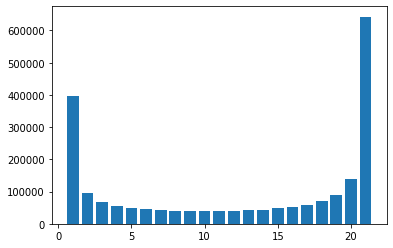

In [22]:
#Method 3: Rank Histogram
# !pip install rank-histogram
# R code: https://rdrr.io/cran/SpecsVerification/src/R/Rankhist.R
from ranky import rankz

#obs = np.asarray(observation.to_array(), dtype=np.float32).squeeze(); #Full data. #DOES NOT WORK if dimensions dont match
obs = np.asarray(obs2.to_array(), dtype=np.float32).squeeze();#small data

obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(preds.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

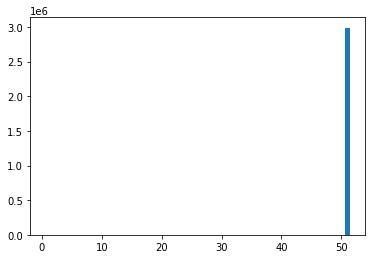

In [90]:
#FOr TIGGE. SLOW!! (OLD)
#Method 3: Rank Histogram
# !pip install rank-histogram
# R code: https://rdrr.io/cran/SpecsVerification/src/R/Rankhist.R
from ranky import rankz

obs = np.asarray(obs3.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(tigge.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

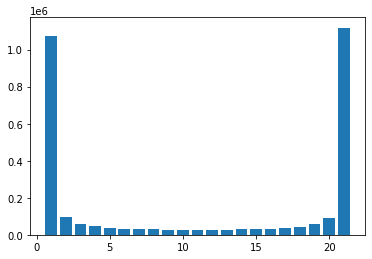

In [23]:
#FOr TIGGE_small
#Method 3: Rank Histogram
# !pip install rank-histogram
# R code: https://rdrr.io/cran/SpecsVerification/src/R/Rankhist.R
from ranky import rankz

obs = np.asarray(obs3.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(tigge_small.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive). looks worse than our preds.!

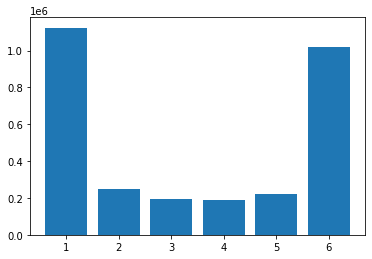

In [96]:
#For Temperature. Should be better. (OLD)
result = rankz(obs_t850, pred_t850, mask)
# plot histogram
plt.bar(range(1,pred_t850.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

In [ ]:
#old code. ignore.

In [ ]:
#result from old code with 50 forecasts. just to show it is still overconfident
result = rankz(obs_t850, pred_t850, mask)
plt.bar(range(1,pred_t850.shape[0]+2), result[0])
plt.show()

In [ ]:
#sanity check: for a random sample
obs = np.random.randn(10, 40, 40)
ensemble = np.random.randn(20, 10, 40, 40)
mask = np.random.randint(0, 2, (10, 40, 40)) #masked where 0/false.
# feed into rankz function
result = rankz(obs, ensemble, mask)
# plot histogram
plt.bar(range(1,ensemble.shape[0]+2), result[0])
# view histogram
plt.show()

In [ ]:
#testing for smaller number of bins (i.e. forecasts) (For old predictions.)
obs_small=obs_z500[:,:,:].squeeze()
pred_small=pred_z500[0:10,:,:,:]
mask=np.ones(obs_small.shape).squeeze()
print(obs_small.shape)
print(pred_small.shape)
print(mask.shape)

result = rankz(obs_small, pred_small, mask)
plt.bar(range(1,pred_small.shape[0]+2), result[0])
plt.show() #overconfident (underdispersive)